# Homework 5 Machine Learning
Shalom-David Anifowoshe and Yiping Deng

First, we try to load the data into python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as la

In [2]:
data = pd.read_csv("data/mfeat-pix.txt",sep='\s+', header=None)

In [3]:
darr = data.values.astype(float)

In [4]:
def img_cat(darr):
    """
    reshape the image and show the image
    """
    img_mat = darr.reshape(16, 15) # reshape the d array
    plt.imshow(img_mat, cmap='gray')
    plt.show()
def imgs_cat(darr):
    for rows in darr:
        img_cat(rows)


In [5]:
img_threes = darr[600:800] #select class 1

# PCA algorithms
## Steps in PCA algorithms

 - centering the data: mapping each vector $x_i \to \bar{x_i}$, where $\bar{x_i} = x_i - \bar{x}$
 - calculating the $\mu_1, \mu_2, ... \mu_m$, where $m$ is the number of principle components
   $\mu_i$ is calculated via $SVD$ algorithm.
   
   1. We calculate the correlation matrix $R$.
   2. Calculate the SVD via $$[U, \Sigma, V^*] = SVD(R)$$, where
   $$ R = U \Sigma V^* $$
   3. Extract the principle components $\mu_1, \mu_2, ... \mu_m$, where $ m < n$, by taking the first $m$ columns of $U$. 
 - Compression: we take each $\mu_1, \mu_2, \mu_3 ... $ and dot product the already centered $\bar{x_i}$ to obtain a vector $v \in \mathbb{R}^m$
 \begin{align*}
 v = \begin{bmatrix}
 \mu_1 \cdot \bar{x_i} \\
  \mu_2 \cdot \bar{x_i} \\
   \mu_3 \cdot \bar{x_i} \\
    \mu_4 \cdot \bar{x_i} \\
    ... \\
    \mu_m \cdot \bar{x_i}
 \end{bmatrix}
 \end{align*}
 - Decompression: we simply calculate
 $$ recovered = \sum_{i = 1}^{m} v_i \cdot \mu_i $$
 

### Concrete implementation of PCA algorithm

In [6]:
def distance(p1, p2):
    diff = p1 - p2
    s = np.sum(np.power(diff, 2))
    return np.sqrt(s)

Let's first take a look at what is in the picture.

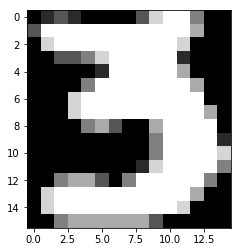

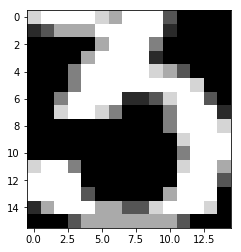

In [7]:
imgs_cat(img_threes[0:2]) # let's take a look into the picture

We will try to normalize the data to the center by calculating the mean value
 and minus every vectors in the training set by the mean value.

In [8]:
def normalize(data):
    # normalize the data set to perform the algorithm
    mean = np.sum(data, axis = 0)
    N, _ = data.shape
    mean = mean / float(N)
    mean_mat = [mean] * N
    print(mean_mat)
    normalized = data - mean_mat
    return normalized, mean

In [9]:
def denormalize(normalized, mean):
    # recover from the normalization
    N, _ = normalized.shape
    mean_mat = [mean] * N
    data = normalized + mean_mat
    return data

In [10]:
%%capture
normalized_threes, mean_threes = normalize(img_threes) # first normalize the data

# calculate the correlation matrix
R = np.corrcoef(normalized_threes.T)

# compute the SVD algorithm
U, s, Vt = la.svd(R)

We have two functions that compress and decompress the data respectively.

In [11]:
def compress(normalized, pc, k):
    # compress the normalized data using pc, the princle component
    pc = pc[:, :k]
    return np.matmul(normalized,pc)

def decompress(compressed, pc, k):
    # recover from compression
    pc = pc[:, :k]
    return np.matmul(compressed,pc.T)

In [12]:
def pca_test(normalized, pc, k):
    return decompress(compress(normalized, pc, k), pc, k)

The variance error can be calculated using $\Sigma$ returned by the $SVD$ algorithm.
To be specific, the error term
$$ E_m = \frac{\sum_{j = m + 1}{n} \sigma_j^2}{\sum_{j = 1}^n \sigma_j^2}$$

In [13]:
def variance_error(sigma,k):
    # for a given sigma vector and k component, calculate the error term
    return np.sum(sigma[k:]) / np.sum(sigma)

The expected $m$, or $k$ mentioned in the question can be quickly determined if given a preserved variance $p$.
$$ m_{expected} = \min_{k \leq m} \{ k \mid (1 - E_k) \geq q \} $$

In [14]:
def pick_k(sigma, percentage):
    for k in range(1, 240):
        if variance_error(sigma, k) < (1.0 - percentage):
            print('k = {} obtains a variance of {}'.format(k, 1.0 - variance_error(sigma, k)))
            return k

### With preseverd variance of $50\%$
Using the technique above, $m_{expected} = 8$. As you can see below, the image is pretty blurry.

k = 8 obtains a variance of 0.5293816034413219


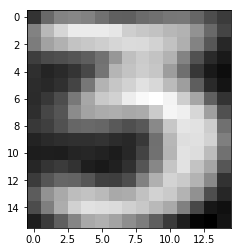

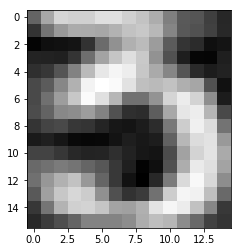

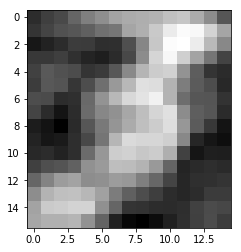

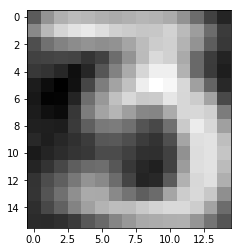

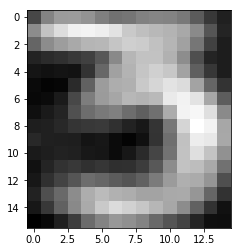

In [15]:
imgs_cat(denormalize(pca_test(normalized_threes, U, pick_k(s, 0.5)), mean_threes)[:5])

### With preseverd variance of $80\%$
Using the technique above, $m_{expected} = 27$. As you can see below, the image is less blurry.

k = 27 obtains a variance of 0.8063078690150481


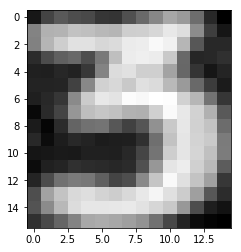

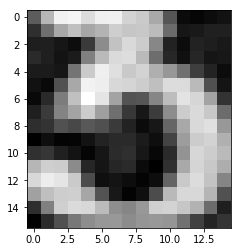

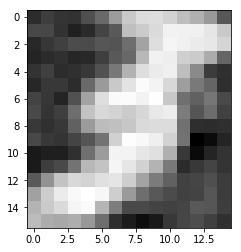

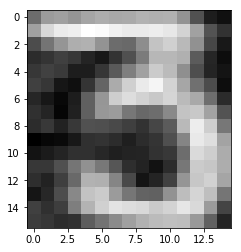

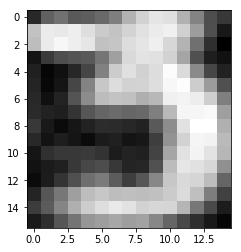

In [16]:
imgs_cat(denormalize(pca_test(normalized_threes, U, pick_k(s, 0.8)), mean_threes)[:5])

### With preseverd variance of $95\%$
Using the technique above, $m_{expected} = 71$. As you can see below, the image is closer to the original.

k = 71 obtains a variance of 0.9509743872148163


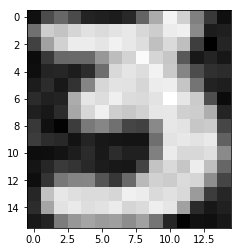

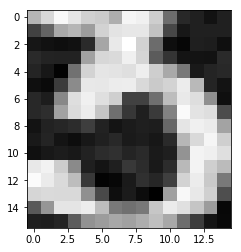

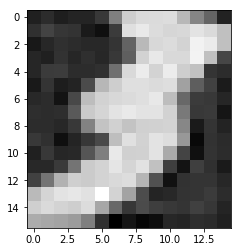

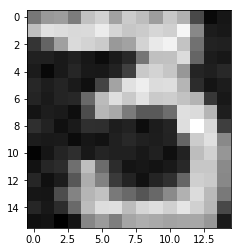

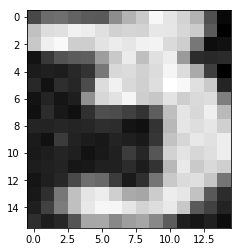

In [17]:
imgs_cat(denormalize(pca_test(normalized_threes, U, pick_k(s, 0.95)), mean_threes)[:5])

### With preseverd variance of $99\%$
Using the technique above, $m_{expected} = 122$. As you can see below, the image is almost identical to the original.

k = 122 obtains a variance of 0.9902471965368619


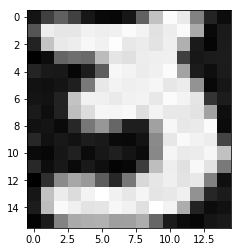

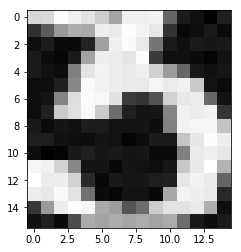

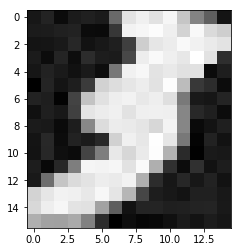

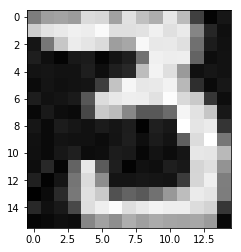

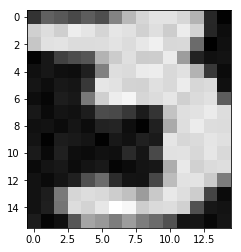

In [18]:
imgs_cat(denormalize(pca_test(normalized_threes, U, pick_k(s, 0.99)), mean_threes)[:5])

## With preseverd variance of $100\%$
We manually tries out values of $k$, or $m$ such that it satisfies such a condition. It turns out to be $m = 199$.
As you can see below, the error is close to zero(not actually zero due to numerical error).

Many of people will expect $m = 240$ instead of $m = 199$ for preserved variance of $100\%$. This is due to the overfitting problem. In the calculation process, the rank of $X$ is $200$. However, after the centering(or normalizing), we have reduced the rank by 1. Thus, the correlation matrix $R$ has at most a rank of $199$. Hence, only $199$ principle components are usable.

In [19]:
variance_error(s, 199) # variance error for k = 199, it is ignorable

4.48395556079047e-16

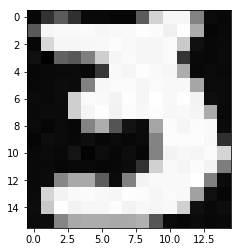

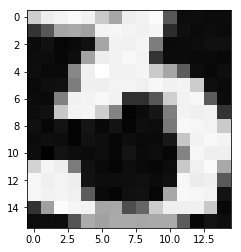

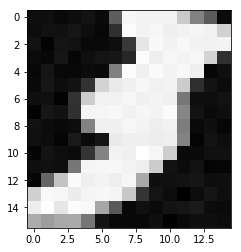

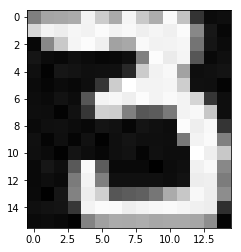

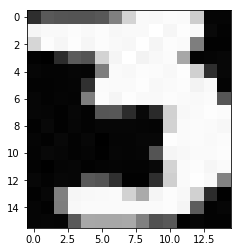

In [20]:
imgs_cat(denormalize(pca_test(normalized_threes, U, 199), mean_threes)[:5]) # show some pictures of k = 199